<a href="https://colab.research.google.com/github/arimaz1881/Speech_denoising_project/blob/master/denoising_cnn_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'preprocessed-auduio:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4793684%2F8114210%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240414%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240414T180215Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3De10ae60605f69f8bff7f9558251e0a9b1ce3f0ee400f85c62b09a29f3f439bfa981f25ee222d920ac67017b4bdd56c0281c2b55752959c761ae8a6d6249b1f82a722ddfed106dfc8cf22c68b2734015e4db2d2d6d08663f1a8921f5f9afcbd4e0315fb70179bc0d93fd12cfca2d02a2a2ac85390dafd9d813d06d1f0a08cd4c2a0a0afe7aa8e8275e0c3b06a2899abdbd3c5c192534f705e74f9db43b3d00e17c382544e558d80aa12e4f8782beb4d869f7741486512bec222b9ccb62b351aff5f6e61c13da6ce8df1319b8b8969aa812356905389fe875bfced99f392d4b4b09590333d668f445e4d5b95329452d10830339941403ab21344a0cf6afe0b8a8c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 977604179 bytes downloaded
Downloaded and uncompressed: preprocessed-auduio
Data source import complete.


In [2]:
# Load saved spectrograms
import pickle

with open('/kaggle/input/preprocessed-auduio/clean_specs.pkl', 'rb') as f:
    clean_specs = pickle.load(f)

with open('/kaggle/input/preprocessed-auduio/noisy_specs.pkl', 'rb') as f:
    noisy_specs = pickle.load(f)

In [3]:
clean_specs_train = clean_specs[:-64]
clean_specs_test = clean_specs[-64:]
noisy_specs_train = noisy_specs[:-64]
noisy_specs_test = noisy_specs[-64:]

In [4]:
import matplotlib.pyplot as plt
import librosa

def draw_spec(spec):
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(spec, sr=48000, x_axis='time', y_axis='log')
    plt.colorbar()

In [5]:
clean_specs_train.shape

(760, 1025, 320)

In [9]:
import torch

batch_size = 56

def split_data(data_np):
    data_batches = [data_np[i:i+batch_size] for i in range(0, len(data_np), batch_size)]

    data_tensors = [torch.tensor(batch, dtype=torch.float32) for batch in data_batches]

    for i, batch_tensor in enumerate(data_tensors):
        print(f"Batch {i+1}: {batch_tensor.shape}")

    return data_tensors

In [10]:
clean_train = split_data(clean_specs_train)
# clean_test = split_data(clean_specs_test)
# noisy_train = split_data(noisy_specs_train)
# noisy_test = split_data(noisy_specs_test)

Batch 1: torch.Size([56, 1025, 320])
Batch 2: torch.Size([56, 1025, 320])
Batch 3: torch.Size([56, 1025, 320])
Batch 4: torch.Size([56, 1025, 320])
Batch 5: torch.Size([56, 1025, 320])
Batch 6: torch.Size([56, 1025, 320])
Batch 7: torch.Size([56, 1025, 320])
Batch 8: torch.Size([56, 1025, 320])
Batch 9: torch.Size([56, 1025, 320])
Batch 10: torch.Size([56, 1025, 320])
Batch 11: torch.Size([56, 1025, 320])
Batch 12: torch.Size([56, 1025, 320])
Batch 13: torch.Size([56, 1025, 320])
Batch 14: torch.Size([32, 1025, 320])


In [8]:
clean_train = split_data(clean_specs_train)
clean_test = split_data(clean_specs_test)
noisy_train = split_data(noisy_specs_train)
noisy_test = split_data(noisy_specs_test)

In [11]:
std, mean = torch.std_mean(noisy_train[0])
normalized_tensor = (noisy_train[0] - mean) / std
std, mean = torch.std_mean(normalized_tensor)
std, mean

(tensor(1.), tensor(3.8588e-09))

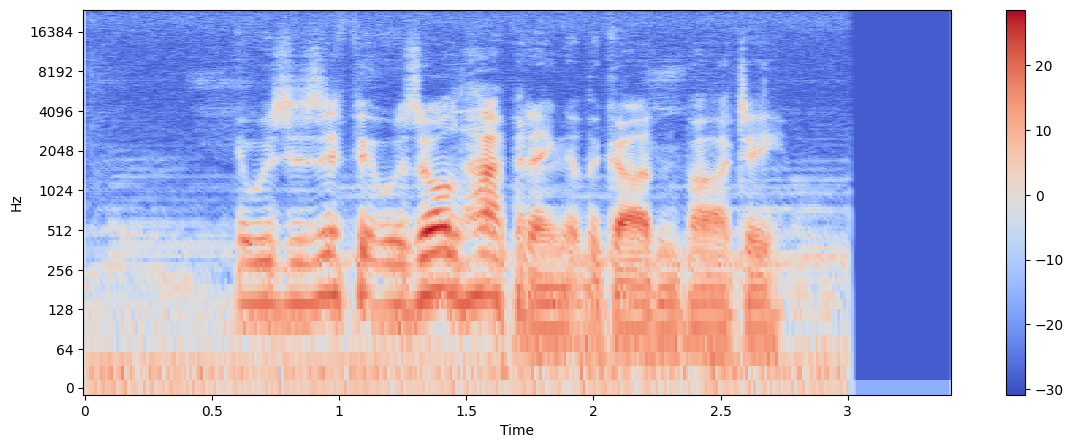

In [ ]:
# after first convolution
draw_spec(x[0][0].detach().numpy())

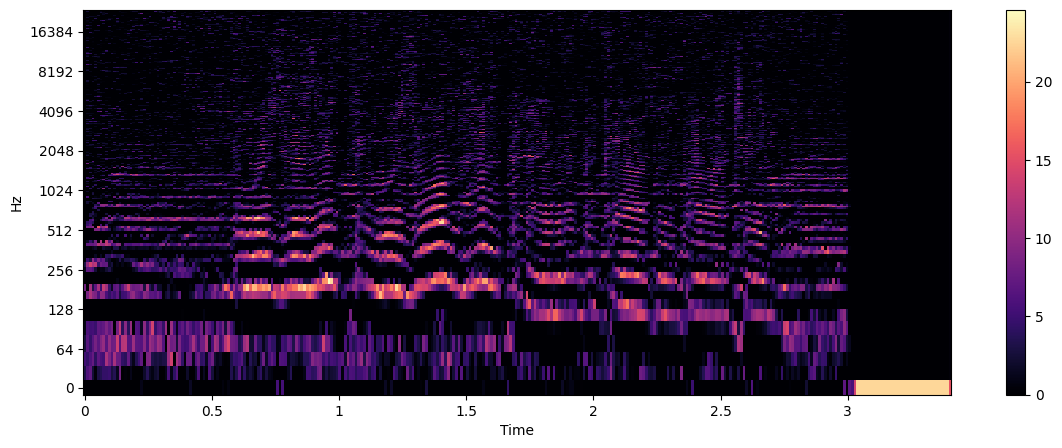

In [ ]:
# after first convolution and relu
draw_spec(x[0][0].detach().numpy())

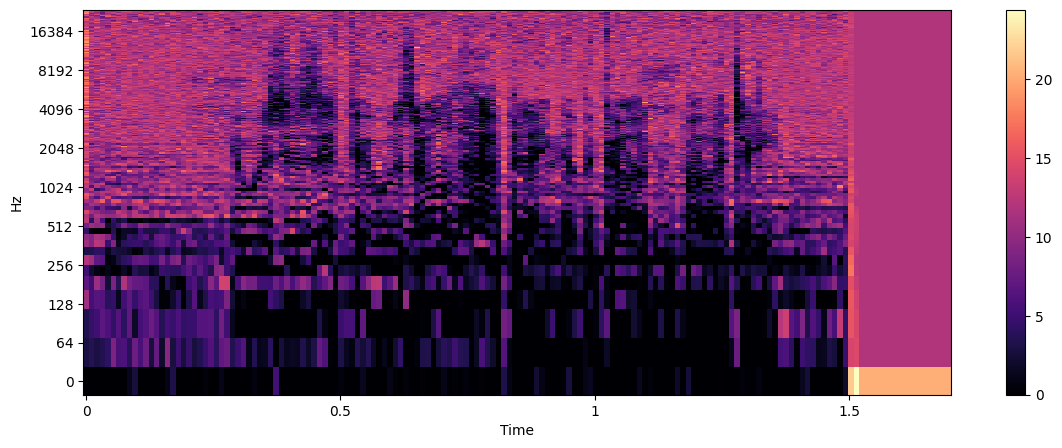

In [ ]:
# after first convolution and relu and maxpool
draw_spec(x[0][0].detach().numpy())

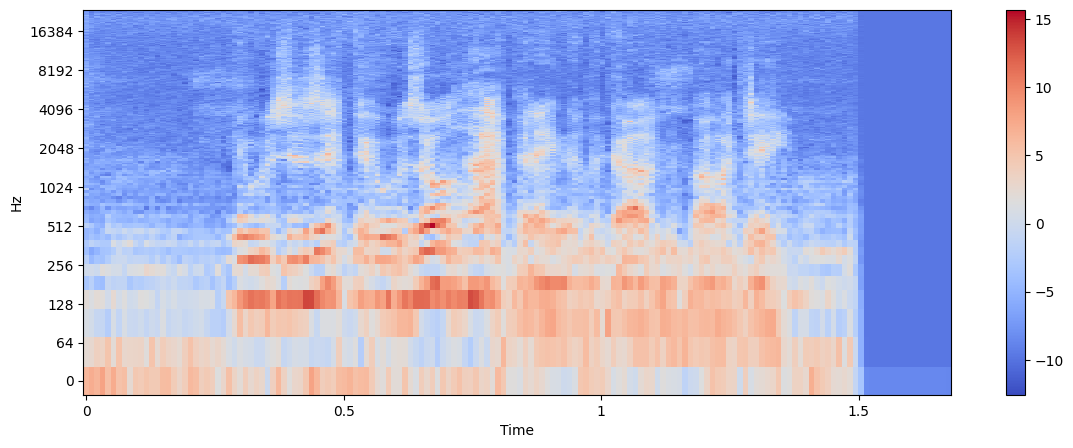

In [ ]:
# after second convolution
draw_spec(x[0][0].detach().numpy())

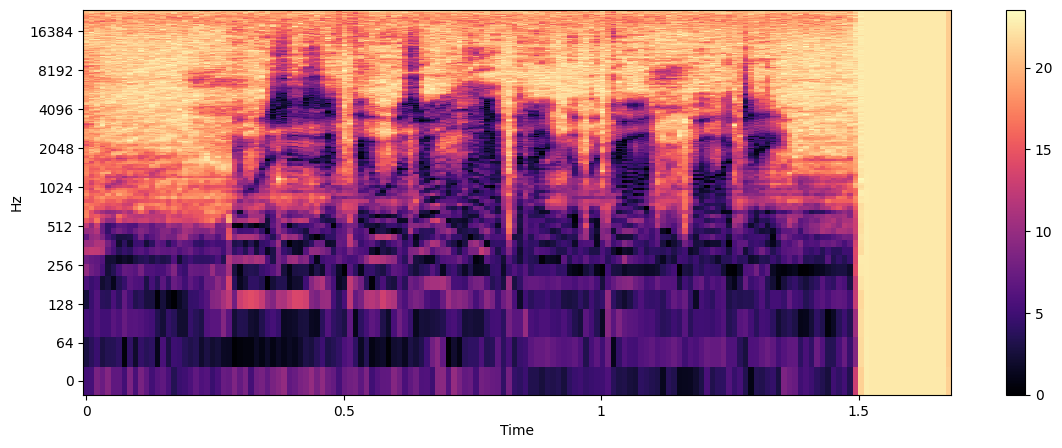

In [ ]:
# after second convolution and relu
draw_spec(x[0][0].detach().numpy())

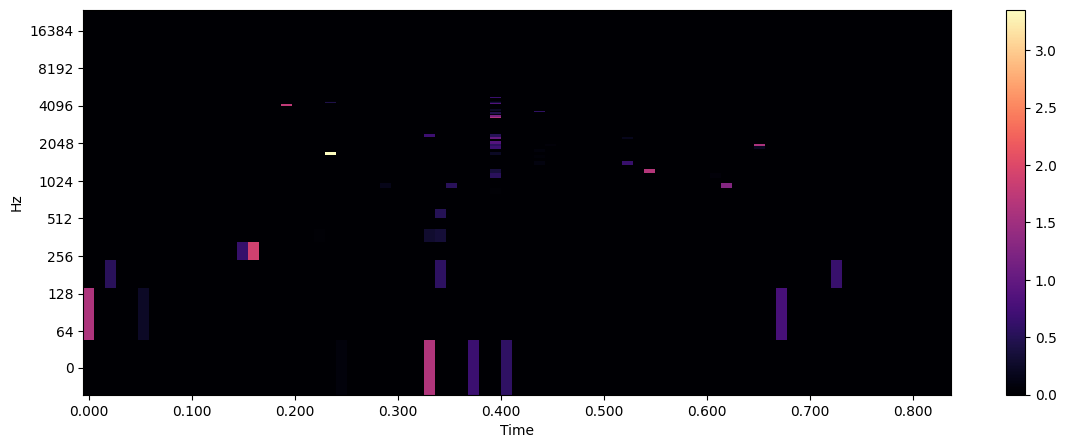

In [ ]:
# after second convolution and relu with maxpool
draw_spec(x[0][0].detach().numpy())

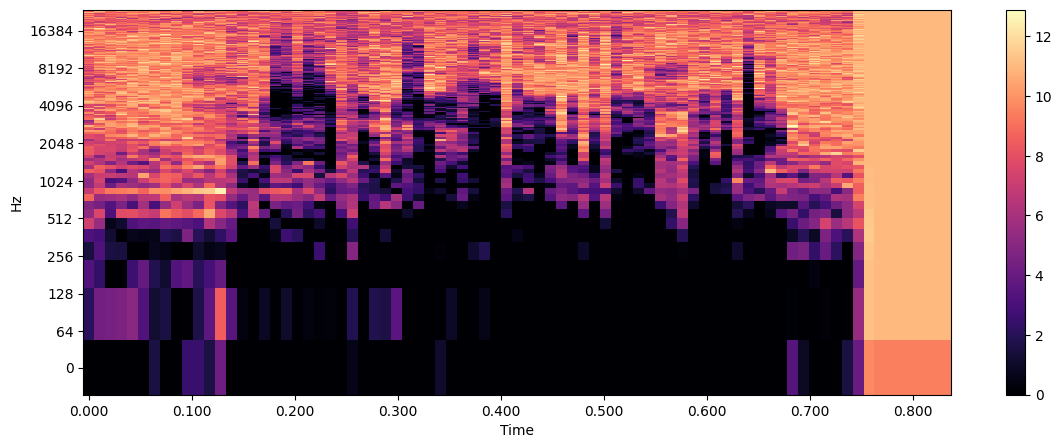

In [ ]:
# after second convolution and relu with stride=2
draw_spec(x[0][0].detach().numpy())

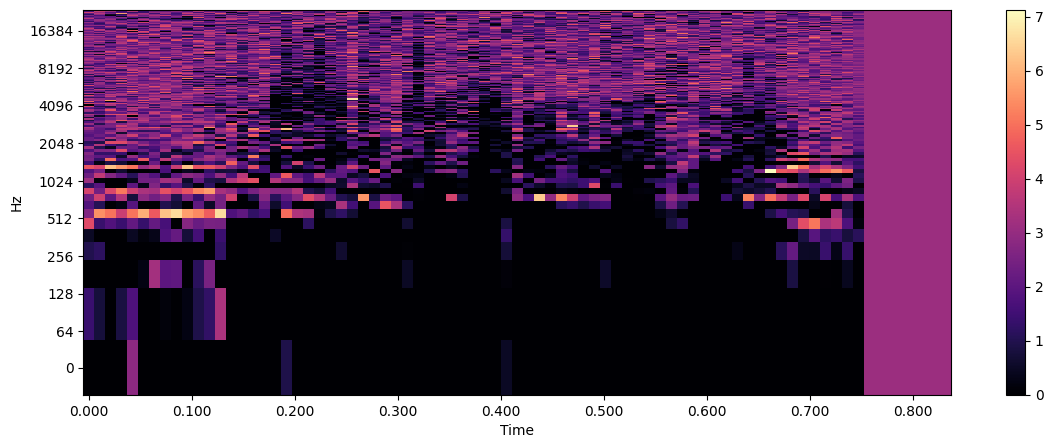

In [ ]:
# after two convolutions with stride=2 and relu
draw_spec(x[0][0].detach().numpy())

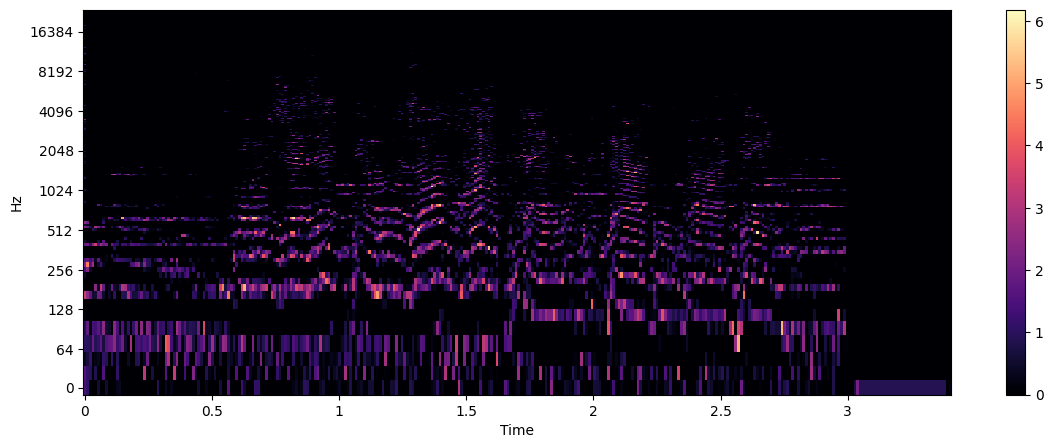

In [ ]:
# after two convolutions with maintaining original sizes
draw_spec(x[0][28].detach().numpy())

In [ ]:
torch.std_mean(x[0][0])

(tensor(0.8604, grad_fn=<StdMeanBackward0>),
 tensor(1.1974, grad_fn=<StdMeanBackward0>))

In [ ]:
x = noisy_train[0].unsqueeze(dim=1) # input shape: [batch_size, image_length, image_width] --> [batch_size, num_channels, image_length, image_width]

x = nn.BatchNorm2d(1)(x)
x = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=2)(x)
x = F.relu(x)
x = F.max_pool2d(x, 2, 2)
x = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2)(x)
x = F.relu(x)

x = nn.BatchNorm2d(32)(x)
x = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2)(x)
x = F.relu(x)
x = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1)(x)
x = F.sigmoid(x)
x = x[:, :, :, :-1]
x.shape

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2)
        self.norm1 = nn.BatchNorm2d(1)
        self.norm2 = nn.BatchNorm2d(32)
        self.convTrans1 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2)
        self.convTrans2 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1)

    def reshape(self, x):
        return x[:, :, :, :-1]

    def encode(self, x):
        x = self.norm1(x)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        return x

    def decode(self, x):
        x = self.norm2(x)
        x = F.relu(self.convTrans1(x))
        x = F.sigmoid(self.convTrans2(x))
        x = self.reshape(x)
        return x

    def forward(self, x):
        x = self.encode(x)
        return self.decode(x)

In [ ]:
# clean_train = split_data(clean_specs_train)
# clean_test = split_data(clean_specs_test)
# noisy_train = split_data(noisy_specs_train)
# noisy_test = split_data(noisy_specs_test)

In [12]:
clean_train = [tensor.unsqueeze(dim=1) for tensor in clean_train]
noisy_train = [tensor.unsqueeze(dim=1) for tensor in noisy_train]
clean_test = [tensor.unsqueeze(dim=1) for tensor in clean_test]
noisy_test = [tensor.unsqueeze(dim=1) for tensor in noisy_test]

In [13]:
clean_train[0].shape

torch.Size([56, 1, 1025, 320])

In [14]:
train_data = list(zip(noisy_train, clean_train))
val_data = list(zip(noisy_test, clean_test))

In [15]:
def train(epoch):
    model.train()

    train_loss = 0 # train loss per epoch

    for inputs, targets in train_data:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print(f'\nTrain Epoch: {epoch} Avr loss: [{train_loss / len(train_data)}]')
    return train_loss / len(train_data)

def val():
    epoch_loss = 0
    model.train(False)


    for inputs, targets in val_data:
        inputs, targets = inputs.to(device), targets.to(device)

        with torch.no_grad():
            out = model(inputs)
            loss = loss_fn(out, targets)

            epoch_loss += loss.item()

    epoch_loss /= len(val_data)
    print(f'Evaluation loss: {epoch_loss}')

    return epoch_loss

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

model = CNN().to(device)

EPOCHS = 50

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.MSELoss()

train_loss_history = []
val_loss_history = []

for epoch in range(EPOCHS):
    train_loss = train(epoch)
    val_loss = val()

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

Device: cuda

Train Epoch: 0 Avr loss: [1261.7699410574776]
Evaluation loss: 1272.6487426757812

Train Epoch: 1 Avr loss: [1252.4298706054688]
Evaluation loss: 1263.6859741210938

Train Epoch: 2 Avr loss: [1245.6611066545759]
Evaluation loss: 1257.5316162109375

Train Epoch: 3 Avr loss: [1241.6895839146205]
Evaluation loss: 1253.91357421875

Train Epoch: 4 Avr loss: [1239.6454816545759]
Evaluation loss: 1252.3799438476562

Train Epoch: 5 Avr loss: [1238.5770525251116]
Evaluation loss: 1251.468017578125

Train Epoch: 6 Avr loss: [1237.9423130580358]
Evaluation loss: 1250.9742431640625

Train Epoch: 7 Avr loss: [1237.5245274135045]
Evaluation loss: 1250.62744140625

Train Epoch: 8 Avr loss: [1237.2335815429688]
Evaluation loss: 1250.3911743164062

Train Epoch: 9 Avr loss: [1237.0241873604912]
Evaluation loss: 1250.229248046875

Train Epoch: 10 Avr loss: [1236.8707624162946]
Evaluation loss: 1250.1167602539062

Train Epoch: 11 Avr loss: [1236.7565743582588]
Evaluation loss: 1250.03515625


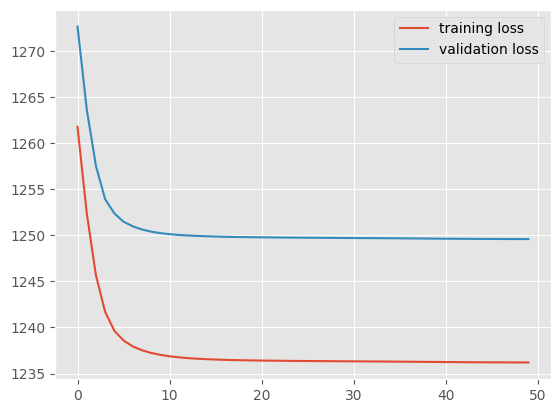

In [19]:
plt.style.use('ggplot')
plt.plot(train_loss_history, label='training loss')
plt.plot(val_loss_history, label='validation loss')
plt.legend()
plt.show()

In [20]:
torch.save(model.state_dict(), 'trained_model.pth')

In [33]:
def get_stft(waveforms: list) -> list:
    '''params: waveforms - list of waveforms represented as numpy arrays
    output: list of spectrograms'''
    specs = []
    for wav in waveforms:
        stft = librosa.amplitude_to_db(abs(librosa.stft(wav)))
        specs.append(stft)

    return specs

def trim_pad(sounds_list):
    threshold = 163397

    for i, tensor in enumerate(sounds_list):
        # trimming too long sequences
        if tensor.shape[1] > threshold:
             sounds_list[i] = tensor[:, :threshold]

        #padding too short
        padding_length = max(0, threshold - tensor.shape[1])
        if padding_length > 0:
            pad_tensor = torch.zeros((tensor.shape[0], padding_length), dtype=tensor.dtype)
            sounds_list[i] = torch.cat([tensor, pad_tensor], dim=1)

    return sounds_list

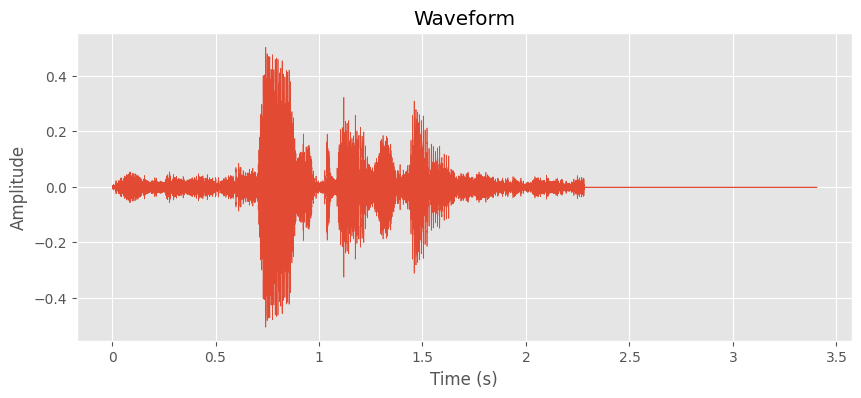

In [42]:
audio_path = 'sample.wav'
waveform, sample_rate = librosa.load(audio_path, sr=48000)
waveform = torch.tensor(waveform)
waveform = trim_pad([waveform.unsqueeze(dim=0)])
# waveform.shape[0]

plt.figure(figsize=(10, 4))
librosa.display.waveshow(waveform[0].numpy(), sr=sample_rate)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

In [45]:
sample_stft = get_stft([waveform[0].numpy()])

In [50]:
sample_stft[0]

array([[[-37.596394 ,   6.8801837,  12.590191 , ..., -37.596394 ,
         -37.596394 , -37.596394 ],
        [-10.143169 ,   7.151476 ,  11.6411495, ..., -37.596394 ,
         -37.596394 , -37.596394 ],
        [ -6.4017434,   4.384553 ,   4.67816  , ..., -37.596394 ,
         -37.596394 , -37.596394 ],
        ...,
        [-37.596394 , -37.596394 , -37.596394 , ..., -37.596394 ,
         -37.596394 , -37.596394 ],
        [-37.596394 , -37.596394 , -37.596394 , ..., -37.596394 ,
         -37.596394 , -37.596394 ],
        [-37.596394 , -37.596394 , -37.371857 , ..., -37.596394 ,
         -37.596394 , -37.596394 ]]], dtype=float32)

In [52]:
tensor_stft = torch.tensor(sample_stft[0], dtype=torch.float32)

In [54]:
tensor_stft = tensor_stft.unsqueeze(dim=0)

In [57]:
denoised_sample = model(tensor_stft.to(device))

In [58]:
import matplotlib.pyplot as plt
import librosa

def draw_spec(spec):
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(spec, sr=48000, x_axis='time', y_axis='log')
    plt.colorbar()

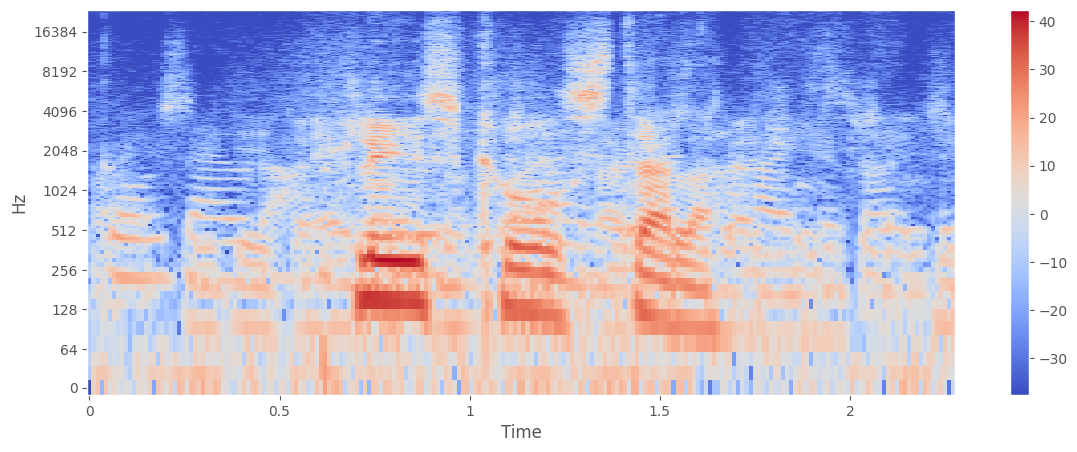

In [67]:
audio_path = 'sample.wav'
wav, sample_rate = librosa.load(audio_path, sr=48000)

X = librosa.stft(wav)
Xdb = librosa.amplitude_to_db(abs(X))
draw_spec(Xdb)

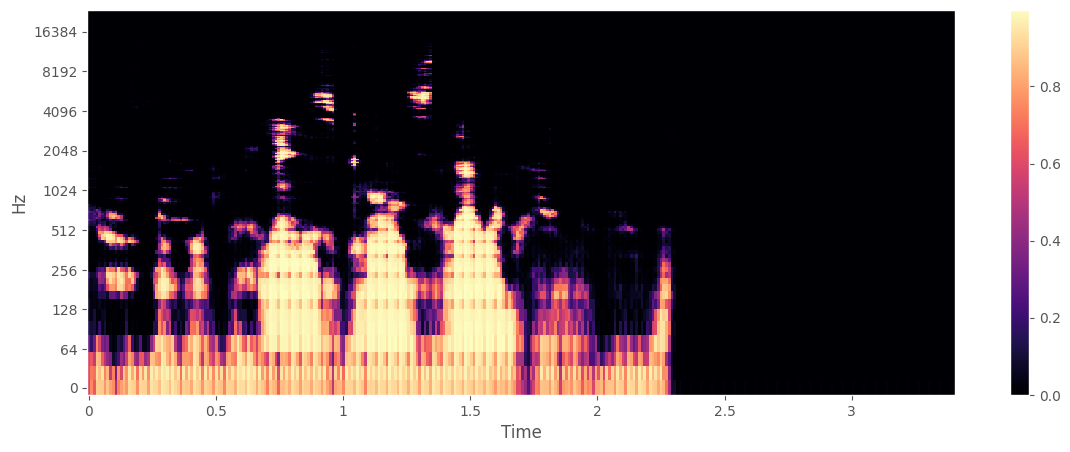

In [61]:
draw_spec(denoised_sample[0][0].cpu().detach().numpy())

In [69]:
import soundfile as sf

denoised_waveform = librosa.istft(denoised_sample[0][0].cpu().detach().numpy())
sf.write('reconstructed_audio.wav', denoised_waveform, 48000)

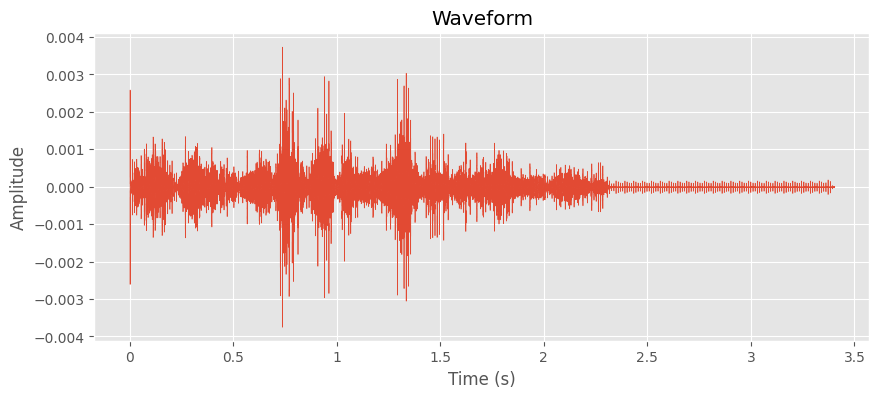

In [71]:

plt.figure(figsize=(10, 4))
librosa.display.waveshow(denoised_waveform, sr=sample_rate)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

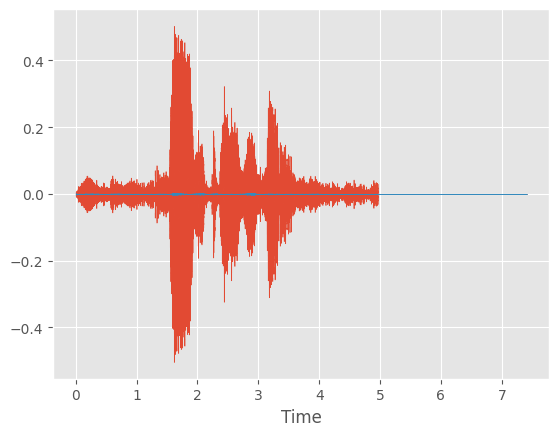

In [73]:
librosa.display.waveshow(waveform[0].numpy())
librosa.display.waveshow(denoised_waveform)
